In [0]:
project_name = 'test_project_1'
#permissions='default'
permissions='fulldata'

In [0]:
pip install pycountry

Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=4b75ea946a52c756dbe4918a0bc10fcb545bc3b5b16edb143046224acfc94cac
  Stored in directory: /root/.cache/pip/wheels/47/15/92/e6dc85fcb0686c82e1edbcfdf80cfe4808c058813fed0baa8f
Successfully built pycountry
Python interpreter will be restarted.


In [0]:
%pip install markupsafe==2.0.1
%pip install rpy2

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached rpy2-3.5.14.tar.gz (219 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-b1167780-4979-4786-8f19-6cdff5f0788c/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-b1167780-4979-4786-8f19-6cdff5f0788c/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmp90b95n89
       cwd: /tmp/pip-install-vzzfvqf5/rpy2_082a7ac69e07464883f87d67bc99d493
  Complete output (16 lines):
  Traceback (most recent call last):
    File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-b1167780-4979-4786-8f19-6cdff5f0788c/lib/python3.9/site-packages/pip/_vendor/pe

In [0]:
%run /Snippets/header_008

In [0]:
import pandas as pd
import pyspark.sql.functions as F
def first(lst):
  return lst[0]
def extract_publication_info(newdf):
  #newdf = df_ani.limit(50)
  newdf = newdf.select('doi','Eid','year','Au','Au_Af','Au_cors','publication_type','openaccess','issn','source','news_cnt','correspondence','Af')


  newdf = newdf.withColumn('Au1', first(newdf['Au']))



  newdf = newdf.withColumn('Au2', F.element_at(newdf['Au'], -1))

  newdf = newdf.withColumn('num_au', F.size(newdf['Au']))

  newdf = newdf.withColumn('Au1_id', F.col('Au1').getItem('auid'))

  newdf = newdf.withColumn('Au2_id', F.col('Au2').getItem('auid'))

  newdf = newdf.withColumn('Au_cor_id', F.col('Au_cors').getItem('auid'))
  #newdf = newdf.withColumn('Au_cor_name', F.col('Au_cors').getItem('given_name'))
  #newdf = newdf.withColumn('cor1_given_name', first(newdf['Au_cor_name']))

  newdf = newdf.withColumn('cor_seq', F.col('Au_cors').getItem('Authorseq'))
  newdf = newdf.withColumn('cor_seq_first', first(newdf['cor_seq']))

  newdf = newdf.withColumn('auth_seq', F.col('Au_Af').getItem('Authorseq'))
  newdf = newdf.withColumn('aff_seq', F.col('Au_Af').getItem('affiliation_seq'))
  newdf = newdf.withColumn("auth_pos", F.expr("array_position(auth_seq, cor_seq_first)"))

  newdf = newdf.withColumn("auth_pos", newdf["auth_pos"].cast(IntegerType()))  
  #newdf = newdf.filter(F.col('aff_seq').isNotNull())
  newdf = newdf.filter(F.col('auth_pos') != 0)
  newdf = newdf.withColumn("aff", F.element_at(newdf['aff_seq'], newdf['auth_pos']))
  newdf = newdf.withColumn("aff_val", F.element_at(newdf['Af'], newdf['aff']))
  newdf = newdf.withColumn("cor_afid", F.col('aff_val').getItem('afid'))

  newdf = newdf.withColumn('given_seq', F.col('Au').getItem('given_name'))
  newdf = newdf.withColumn("cor1_given_name", F.element_at(newdf['given_seq'], newdf['cor_seq_first']))
  display(newdf.limit(10))

  return newdf
def get_smc_classification(newdf):
  df_smc_ani = spark.read.format("parquet").load(basePath+tablename_smc_complete)
  newdf2 = newdf.join(df_smc_ani,'Eid', 'inner')
  return newdf2

def get_gender(newdf):
  df_gender = spark.read.format("parquet").load(basePath+tablename_gender_inference)
  #non_null_count = newdf.where(F.col('Au1_id').isNotNull()).count()
  mergedf = df_gender.join(newdf, newdf.Au1_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender,newdf.doi,newdf.news_cnt,newdf.Au,newdf.Eid, newdf.year, newdf.publication_type,newdf.openaccess, newdf.issn, 
      newdf.num_au, newdf.Au1_id,newdf.Au2_id,newdf.Au_cor_id, newdf.srcid, newdf.subfield_article, newdf.subfield_journal, newdf.subfield_hybrid,newdf.correspondence,
      newdf.cor1_given_name, newdf.cor_afid)
  mergedf = mergedf.withColumnRenamed('Inferred_Probable_Gender', 'Au1_gender')

  mergedf2 = df_gender.join(mergedf, mergedf.Au2_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf.doi,mergedf.news_cnt,mergedf.Au,mergedf.Eid, mergedf.year, mergedf.publication_type,mergedf.openaccess, mergedf.issn, 
      mergedf.num_au, mergedf.Au1_id,mergedf.Au2_id,mergedf.Au_cor_id, mergedf.srcid, mergedf.subfield_article, mergedf.subfield_journal, mergedf.subfield_hybrid, mergedf.Au1_gender,mergedf.correspondence,mergedf.cor1_given_name,mergedf.cor_afid)
  mergedf2 = mergedf2.withColumnRenamed('Inferred_Probable_Gender', 'Au2_gender')

  #mergedf2 = mergedf2.withColumn('no_cor', F.size(mergedf2['Au_cor_id']))
  #display("len os final4 ", mergedf2.count(),"\n")

  mergedf2 = mergedf2.withColumn('cor_au1', first(mergedf2['Au_cor_id']))

  #display(final_data4.limit(20))

  mergedf3 = mergedf2.filter(F.col('cor_au1').isNotNull())
  display("no of not null cor au",mergedf3.count(),"\n")

  mergedf4 = df_gender.join(mergedf3, mergedf3.cor_au1 == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf3.doi,mergedf3.news_cnt,mergedf3.Au,mergedf3.Eid, mergedf3.year, mergedf3.publication_type,mergedf3.openaccess, mergedf3.issn, 
      mergedf3.num_au, mergedf3.Au1_id,mergedf3.Au2_id,mergedf3.Au_cor_id, mergedf3.srcid, mergedf3.subfield_article, mergedf3.subfield_journal, mergedf3.subfield_hybrid, mergedf3.Au1_gender,mergedf3.Au2_gender,mergedf3.cor_au1,mergedf3.correspondence,mergedf3.cor1_given_name, mergedf3.cor_afid)
  mergedf4 = mergedf4.withColumnRenamed('Inferred_Probable_Gender', 'cor_gender')

  return mergedf4

def merge_news_cnt(scop):
  scop = scop.filter(func.col('year') >= 2018)
  scop = scop.filter(func.col('year') <= 2022)
  df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_news_final.csv")
  display("# doi data from crossref and altmetric ",df1.count(),"\n")
  df = scop.join(df1, 'doi','inner')
  df = df.withColumn("news_cnt", df["news_cnt"].cast(IntegerType()))
  return df

from pyspark.sql.functions import lower

df_ani = spark.read.format("parquet").load(basePath+tablename_ani)

display("len of df_ani ",df_ani.count(),"\n")
dd = df_ani.withColumn('language', first(df_ani['meta_language']))
d1 = dd.withColumn('language_s', lower(dd['language']))

d2 = d1.filter(func.col('language_s') == 'english')
display("len of df_ani in english ",d2.count(),"\n")

with_news = merge_news_cnt(d2)
display("merged data len between crossref and scopus ",with_news.count(),"\n")

newdf = extract_publication_info(with_news)

df_class = get_smc_classification(newdf)
final_data = get_gender(df_class)
display(final_data.count(),"\n")
final_data2 = final_data.dropna(subset=["doi"])
display(final_data2.count(),"\n")

##extracting sci_val topic for each publication
df_top_eids = spark.read.format("parquet").load(basePath+tablename_top_topic_eid)

final_data3 = final_data2.join(df_top_eids,'Eid','inner')
#display(final_data3.count())
display(final_data3.limit(10))


import pyspark.sql.functions as F
import pyspark.sql.column as C

def find_sjr(met,yy,yr):

  ylst = F.tolist(yy)

  #index = ylst.index(yr)
  #sjr = m[index]
  return m


df_sources = spark.read.format("parquet").load(basePath+tablename_sources)

data = final_data3.join(df_sources,'srcid','inner').select(df_sources.metrics_calculations,df_sources.sourcetitle,df_sources.openaccess_status,final_data3.srcid,final_data3.doi,final_data3.news_cnt,final_data3.year,
final_data3.publication_type, final_data3.issn, final_data3.num_au,final_data3.Au1_id, final_data3.subfield_article,final_data3.subfield_journal, final_data3.Au1_gender,final_data3.TopicId, 
final_data3.cor_gender,final_data3.cor_au1,final_data3.correspondence, final_data3.cor1_given_name, final_data3.cor_afid)

display("len of merged data between src ", data.count(),"\n")

data = data.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
data = data.withColumn('year_SJR', F.col('metrics_calculations').getItem('year'))

#data = data.withColumn('SJR', find_sjr(data['SJR_lst'],data['year_SJR'], data['year']))
data = data.withColumn("pos", F.expr("array_position(year_SJR, year)"))


data = data.withColumn("pos", data["pos"].cast(IntegerType()))  
data = data.withColumn("SJR", F.element_at(data['SJR_lst'], data['pos']))

data = data.withColumn('cor_af', first(data['correspondence']))
data = data.withColumn('cor_coun', F.col('cor_af').getItem('country'))



import pycountry
import pyspark.sql.functions as F

def convert_country_short_name(country_short_name):
  #country = pycountry.countries.get(alpha_2=country_short_name)
  if len(country_short_name) == 3:
    country = pycountry.countries.get(alpha_3=country_short_name)
  else:
    country = pycountry.countries.get(alpha_2=country_short_name)

  return country.name if country else None

@F.udf(returnType=F.StringType())
def my_udf(country_short_name):
  return convert_country_short_name(country_short_name)

data = data.filter(F.col('cor_coun').isNotNull())
data = data.withColumn("country_name", my_udf(data["cor_coun"]))
#un_full_coun = un_name.withColumn("country_name", my_udf(un_name["cor_coun"]))

df_ipr = spark.read.format("parquet").load(basePath+tablename_ipr)
data = data.join(df_ipr,[data.cor_afid == df_ipr.afid],'inner')
display(data.limit(10))

val_data = data.filter(func.col('cor_gender') != 'unknown')

#val_un = data.filter(func.col('cor_gender') == 'unknown')



display("len of data whose cor_gender is not unknown ",val_data.count(),"\n")

display(val_data.limit(5),"\n")


#val_un = data.filter(func.col('cor_gender') == 'unknown')
df_apr = spark.read.format("parquet").load(basePath+tablename_apr)
#un_full_coun = val_un.join(df_apr,val_un.cor_au1 == df_apr.auid,'inner')
un_full_coun = data.filter(func.col('cor_gender') == 'unknown')

display("len of unknown name ", un_full_coun.count(),"\n")
un_full_coun = un_full_coun.filter(F.col('cor1_given_name').isNotNull())
un_full_coun = un_full_coun.filter(F.col('country_name').isNotNull())
display("len of unknown name after dropping null country and given name ", un_full_coun.count(),"\n")
df_wos = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/wos_gender_firstname.csv")
#df_wos.printSchema()
#df_wos = df_wos.filter(func.col('country') == 'China')
newfile = un_full_coun.join(df_wos,[un_full_coun.cor1_given_name == df_wos.givenname,un_full_coun.country_name == df_wos.country],'inner')
display("len or merged gender with wos ", newfile.count(),"\n")


PROJECT DETAILS:
Project identifier: test_project_1
Cluster data access level: fulldata


In [0]:
ddf2 = newfile.drop("cor_gender")
ddf3 = ddf2.withColumnRenamed("gender", "cor_gender")
#ddf3.printSchema()
#display(ddf3.select('cor_gender').distinct())
ddf4 = ddf3.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type', 'cor_au1').toPandas()
print(ddf4.head(5)) 

ddfx = val_data.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type','cor_au1').toPandas()
display(len(ddfx),"\n")
display(len(ddf4),"\n")
ddf = ddfx.append(ddf4, ignore_index = True)
display(len(ddf),"\n")

EXECUTION DETAILS:
Spark version: 11.3.x-scala2.12, 
Cluster Node Type: i3.xlarge, 
Driver Node Type: c4.2xlarge, 
Worker Node Type: i3.xlarge


In [0]:
###new version
smc = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/sm_journal_classification.csv")
smc = smc.select('Domain_English','Field_English','SubField_English').toPandas()
smc = smc.dropna()
smc = smc.drop_duplicates()
print(len(smc))
smc['SubField_English'] = smc['SubField_English'].str.lower()
ddf['subfield_article'] = ddf['subfield_article'].str.lower()

#print(smc.dtypes)
total = smc.merge(ddf,left_on='SubField_English',right_on = 'subfield_article',how = 'inner')
print(len(total))

In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))
us.to_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv", index = False)

## merge the github and media file with us data

In [0]:
import pandas as pd

#load the saved us data
t = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")

ff = t[t['news_cnt'] > 0]
print("number of unique doi in cited us data ",ff['doi'].nunique())
print("length of total data ",len(t))
print("length of total cited data ",len(ff))

#remove the retracted dois
ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
total = ff[~ff['doi'].isin(ids_to_remove)]
print("length of data after removing retracted ids ",len(total))
print("total mention ",total['news_cnt'].sum())
total = total.drop_duplicates(subset = ['doi'])
print("len of total after dropping duplicate doi ",len(total))

#merge dois with the media outlet names
m = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_media_for_databricks.csv")
media = m.toPandas()
new_total =total.merge(media, on = ['doi'], how = 'inner') 
print(len(new_total))
print(new_total['doi'].nunique())
print(new_total['media'].nunique())
print(new_total.dtypes)
new_total = new_total.drop_duplicates(subset = ['doi','media'])
print("new_total after droppimg duplicate doi-media pair",len(new_total))


media_github = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/media_class_github3.csv")
media_github = media_github.toPandas()
media_github['media'] = media_github['media'].str.strip()


new_total['media'] = new_total['media'].str.strip()

merged = new_total.merge(media_github, on = ['media'], how = "inner")

print(len(merged))
print(merged['media'].nunique())
print(merged['git'].nunique())
print("xxx ", merged['doi'].nunique())

###new
merged = merged.drop_duplicates(subset = ['doi','git'])
print(len(merged))
merged = merged.drop_duplicates(subset = ['doi','media'])
print(len(merged))
print(merged['media'].nunique())
print(merged['git'].nunique())
print("xxx ", merged['doi'].nunique())


number of unique doi in cited us data  129439
length of total data  1014175
length of total cited data  129451
length of data after removing retracted ids  129440
total mention  1405538
len of total after dropping duplicate doi  129428
1405448
129428
5113
Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
media                 object
is_top                object
dtype: object
new_total after droppimg duplicate doi-media pair 1195149
366164
674
631
xxx  61596
361120
361120
662
631
xxx  61596


In [0]:
print(total[total['issn'] == "00278424"])

           Domain_English                      Field_English  \
9        Applied Sciences  Agriculture, Fisheries & Forestry   
153      Applied Sciences  Agriculture, Fisheries & Forestry   
193      Applied Sciences  Agriculture, Fisheries & Forestry   
921      Applied Sciences  Agriculture, Fisheries & Forestry   
1416     Applied Sciences  Agriculture, Fisheries & Forestry   
...                   ...                                ...   
1013496  Natural Sciences                Physics & Astronomy   
1013523  Natural Sciences                Physics & Astronomy   
1013553  Natural Sciences                Physics & Astronomy   
1013839  Natural Sciences                Physics & Astronomy   
1014104  Natural Sciences                Physics & Astronomy   

               SubField_English  srcid openaccess_status  \
9        agronomy & agriculture  21121                NO   
153      agronomy & agriculture  21121                NO   
193      agronomy & agriculture  21121             

In [0]:
a = pd.DataFrame()
a['srcid'] = t['srcid']
a['SJR'] = t['SJR']
print(len(a))
a = a.drop_duplicates()
print(len(a))

'''q1 = t['SJR'].quantile(0.25)
q2 = t['SJR'].quantile(0.50)
q3 = t['SJR'].quantile(0.75)
print(q1," ",q2," ",q3)'''


q1 = a['SJR'].quantile(0.25)
q2 = a['SJR'].quantile(0.50)
q3 = a['SJR'].quantile(0.75)
print(q1," ",q2," ",q3)



1014175
23670
0.631   0.997   1.632


In [0]:
print(merged.head(5))

     Domain_English                      Field_English  \
0  Applied Sciences  Agriculture, Fisheries & Forestry   
2  Applied Sciences  Agriculture, Fisheries & Forestry   
3  Applied Sciences  Agriculture, Fisheries & Forestry   
4  Applied Sciences  Agriculture, Fisheries & Forestry   
5  Applied Sciences  Agriculture, Fisheries & Forestry   

         SubField_English        srcid openaccess_status  \
0  agronomy & agriculture  21100941001               YES   
2  agronomy & agriculture        23571                NO   
3  agronomy & agriculture  10600153309               YES   
4  agronomy & agriculture  21100200805               YES   
5  agronomy & agriculture  10600153309               YES   

                            doi  news_cnt  year      issn  num_au  ...  \
0     10.3389/fsufs.2020.577723        21  2020  2571581X       5  ...   
2       10.1126/science.aaz5670        14  2019  00368075       1  ...   
3  10.1371/journal.pone.0219847        22  2019  19326203       3  .

In [0]:
df_apr = spark.read.format("parquet").load(basePath+tablename_apr)
display(df_apr.filter(func.col('auid') == 7006567885))


auid,ASJC,ASJC_frequency_I,SUBJABBR,SUBJABBR_frequency_I,affiliation_current_full,given_name_pn,initials_pn,surname_pn,indexed_name_pn,orcid
7006567885,"List(1902, 2310, 1103, 1110, 2807, 1909, 2307, 2800, 2105, 1906, 2400, 2726, 2700, 1600, 1311, 2723, 1105, 1107, 1804, 1307, 2605, 2306, 1908, 1710, 2739, 2312, 2309, 1502, 1314, 2403, 2611, 2215, 1106, 2205, 1300, 2802, 3304, 2305, 2725, 1000, 2406, 2404, 2708, 1313, 2402, 1706, 3301, 1111, 2303, 1911, 1901, 1703, 1109, 1904, 2204, 3308, 1303, 2311, 2613, 2200, 1104, 2301, 2304, 3305, 3100, 1100, 1305, 1101, 1312, 1900, 1907, 2734, 3309, 1910, 2300)","List(9, 3, 2, 3, 1, 1, 1, 8, 1, 3, 10, 13, 101, 7, 24, 1, 83, 6, 3, 9, 2, 11, 1, 1, 3, 8, 1, 5, 9, 6, 7, 4, 11, 1, 32, 1, 1, 6, 3, 26, 6, 81, 2, 5, 21, 10, 1, 38, 64, 5, 1, 2, 1, 7, 5, 1, 17, 2, 5, 1, 8, 2, 20, 1, 3, 27, 23, 1, 18, 4, 1, 1, 1, 1, 22)","List(IMMU, ENGI, MEDI, EART, BIOC, AGRI, DECI, MATH, ENVI, NEUR, COMP, SOCI, PHYS, CHEM, CENG, MULT, ENER)","List(124, 11, 124, 33, 137, 180, 3, 14, 140, 10, 13, 5, 3, 7, 5, 26, 1)","List(List(20 UCB, University of Colorado Boulder, 60000221, null, 60000221, Boulder, United States, usa, 80309-0020, University of Colorado Boulder, author, Colorado Boulder, University of, CO, parent))",Noah G.,N.G.,Fierer,Fierer N.,null


In [0]:
print("no of unique doi in merged ",merged['doi'].nunique())
print("no of unique doi in unmatched ",new_total['doi'].nunique())
print("len of media before merging with github ", len(new_total))
#print(media.head(5))
print("len of merged ",len(merged))
a = merged.drop_duplicates(subset = ['doi','git'])
print("len of merged after dropping duplicate doi git pair ",len(a))
print("unique doi in a ",a['doi'].nunique())

no of unique doi in merged  61596
no of unique doi in unmatched  129428
len of media before merging with github  1195149
len of merged  361120
len of merged after dropping duplicate doi git pair  361120
unique doi in a  61596


In [0]:
361120/1195149

Out[12]: 0.3021547940884358

## create table of doi, local_count, national_count, international_count

In [0]:
special = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/specialty_picked.csv")
special = special.toPandas()
print(special.dtypes)

##sanity check: special should have no intersection with merged
a = set(special['media'])
b = set(merged['media'])
print(a.intersection(b))



media    object
count    object
dtype: object
set()


In [0]:
#create table od doi vs total_mention
import numpy as np
dummy = merged.copy()

doi_total = new_total['doi'].value_counts().reset_index()
doi_total.columns = ['doi','total_count']

#doi_total = dummy['doi'].value_counts().reset_index()
#doi_total.columns = ['doi','total_count']

#create table for special
sp = special.merge(new_total, on = ['media'],how = 'inner')
doi_sp = sp['doi'].value_counts().reset_index()
doi_sp.columns = ['doi','sp_count']

#create table for doi vs local_mention
local = dummy[dummy['type'] == "local"]
doi_local = local['doi'].value_counts().reset_index()
doi_local.columns = ['doi','local_count']

#create table for doi vs national_mention
nat = dummy[dummy['type'] == "national"]
doi_nat = nat['doi'].value_counts().reset_index()
doi_nat.columns = ['doi','national_count']

#create table for doi vs international_mention
internat = dummy[dummy['type'] == "international"]
doi_internat = internat['doi'].value_counts().reset_index()
doi_internat.columns = ['doi','international_count']

merge1 = doi_total.merge(doi_local, on = ['doi'], how  = "left")

merge2 = merge1.merge(doi_nat, on = ['doi'], how  = "left")

merge3 = merge2.merge(doi_internat, on = ['doi'], how  = "left")

merge4 = merge3.merge(doi_sp, on = ['doi'], how  = "left")

print("len of total table ",len(merge4))
print("len of total doi count ",len(doi_total))

merge4['local_count'] = merge4['local_count'].replace(np.nan, 0)
merge4['national_count'] = merge4['national_count'].replace(np.nan, 0)
merge4['international_count'] = merge4['international_count'].replace(np.nan, 0)
merge4['sp_count'] = merge4['sp_count'].replace(np.nan, 0)

print(merge4.isna().sum())


len of total table  129428
len of total doi count  129428
doi                    0
total_count            0
local_count            0
national_count         0
international_count    0
sp_count               0
dtype: int64


In [0]:
#print(merge4['doi'].nunique())
merge4.head(10)

,doi,total_count,local_count,national_count,international_count,sp_count
0,10.1038/s41591-020-0820-9,755,101.0,67.0,27.0,43.0
1,10.1038/s42003-022-03334-8,710,87.0,31.0,17.0,27.0
2,10.1126/science.abj0016,640,93.0,64.0,23.0,39.0
3,10.1016/j.icarus.2021.114594,602,86.0,25.0,14.0,15.0
4,10.1126/science.abb5793,601,119.0,52.0,23.0,40.0
5,10.1038/s41558-022-01426-1,572,84.0,26.0,9.0,35.0
6,10.1126/science.aap9559,568,78.0,62.0,23.0,30.0
7,10.1126/sciadv.abd3083,552,64.0,45.0,9.0,38.0
8,10.1038/s41591-022-01689-3,550,54.0,29.0,17.0,44.0
9,10.1038/s41586-022-04788-w,549,92.0,28.0,15.0,35.0


In [0]:
test = merge4.copy()
test['tt'] = test['local_count']+test['international_count']+test['national_count']+test['sp_count'] 
#print(test[test['tt'] == 0])
test['tt'] = test['total_count'] - test['tt']
print(test[test['tt'] < 0])

Empty DataFrame
Columns: [doi, total_count, local_count, national_count, international_count, sp_count, tt]
Index: []


In [0]:
cat = []
for ind in merge4.index:
  if merge4['local_count'][ind] > 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] > 0:
    cat.append("all")
  elif merge4['local_count'][ind] > 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] <= 0:
    cat.append("local:nat")

  elif merge4['local_count'][ind] > 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] > 0:
    cat.append("local:inter")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] > 0:
    cat.append("nat:inter")

  elif merge4['local_count'][ind] > 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] <= 0:
    cat.append("local")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] <= 0:
    cat.append("national")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] > 0:
    cat.append("inter")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] <= 0:
    cat.append("0")

merge4['cat'] = cat

In [0]:
print(len(merge4))
tot = merge4.merge(total,on=['doi'],how = "inner")
print(len(tot))

129428
129428


In [0]:
tot.head(5)

,doi,total_count,local_count,national_count,international_count,sp_count,cat,Domain_English,Field_English,SubField_English,...,num_au,cor_gender,TopicId,Au1_gender,country_name,SJR,subfield_article,preferred_name,org_type,cor_au1
0,10.1038/s41591-020-0820-9,755,101.0,67.0,27.0,43.0,all,Health Sciences,Biomedical Research,virology,...,5,male,1131033,male,United States,19.536,virology,Scripps Research Institute,resi,15768994000
1,10.1038/s42003-022-03334-8,710,87.0,31.0,17.0,27.0,all,Natural Sciences,Biology,plant biology & botany,...,3,F,4048,unknown,United States,2.251,plant biology & botany,University of Florida,univ,7402490034
2,10.1126/science.abj0016,640,93.0,64.0,23.0,39.0,all,Applied Sciences,"Agriculture, Fisheries & Forestry",fisheries,...,18,male,5235,unknown,United States,14.589,fisheries,Stanford University School of Medicine,meds,7006375689
3,10.1016/j.icarus.2021.114594,602,86.0,25.0,14.0,15.0,all,Natural Sciences,Physics & Astronomy,astronomy & astrophysics,...,18,male,3644,male,United States,1.361,astronomy & astrophysics,Jet Propulsion Laboratory,resi,23977658400
4,10.1126/science.abb5793,601,119.0,52.0,23.0,40.0,all,Health Sciences,Biomedical Research,microbiology,...,5,male,1102558,male,United States,12.556,microbiology,Harvard T.H. Chan School of Public Health,univ,6603040788


In [0]:
##new test
sep = tot.copy()
bin_loc, bin_nat, bin_int, bin_sp = [],[],[],[]
for ind in sep.index:
  if sep['local_count'][ind] > 0:
    bin_loc.append(1)
  else:
    bin_loc.append(0)
  if sep['national_count'][ind] > 0:
    bin_nat.append(1)
  else:
    bin_nat.append(0)
  if sep['international_count'][ind] > 0:
    bin_int.append(1)
  else:
    bin_int.append(0)
  if sep['sp_count'][ind] > 0:
    bin_sp.append(1)
  else:
    bin_sp.append(0)
sep['bin_loc'] = bin_loc
sep['bin_nat'] = bin_nat
sep['bin_int'] = bin_int
sep['bin_sp'] = bin_sp

In [0]:
def domain(a):
  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  gender = []
  
  for ind in a.index:
    if a['year'][ind] == 2018:
      con_18.append(1)
    else:
      con_18.append(0)


    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append("female")
    else:
      gender.append("male") 

  for ind in a.index:
    if a['year'][ind] == 2019:
      con_19.append(1)
    else:
      con_19.append(0)

  for ind in a.index:
    if a['year'][ind] == 2020:
      con_20.append(1)
    else:
      con_20.append(0)

  for ind in a.index:
    if a['year'][ind] == 2021:
      con_21.append(1)
    else:
      con_21.append(0)

  for ind in a.index:
    if a['year'][ind] == 2022:
      con_22.append(1)
    else:
      con_22.append(0)
  
  
  a['con_18'] = con_18
  a['con_19'] = con_19
  a['con_20'] = con_20
  a['con_21'] = con_21
  a['con_22'] = con_22
  a['gender'] = gender
  a['srcid'] = a['srcid'].astype(str)
  return a


In [0]:
print(len(sep))
print(sep['doi'].nunique())

129428
129428


In [0]:
new = sep.copy()
new = new.drop(columns=['cor_au1'], axis = 1)
q1 = t['SJR'].quantile(0.25)
q2 = t['SJR'].quantile(0.50)
q3 = t['SJR'].quantile(0.75)

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q

#a = domain(new[new['Domain_English'] == 'Applied Sciences']) #local, - insig - gendermale est = -0.02444

#a = domain(new[new['Domain_English'] == 'Arts & Humanities']) #local - insig - gendermale est = -0.02744

#a = domain(new[new['Domain_English'] == 'Economic & Social Sciences']) #local - insig - gendermale est = 0.04223

#a = domain(new[new['Domain_English'] == 'Health Sciences']) #local - insig - gendermale est = -0.013663

#a = domain(new[new['Domain_English'] == 'Natural Sciences']) #local - insig - gendermale est = 0.00250

a = domain(new) # local (gender+q+Field_English+year+openaccess_status)- sig - gendermale est = -0.05996, p val = 0.000756 *** #national - insig #international - insig #sp - insig
###question about this part. If I control for SubField. no significant difference. What should I do?

import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(a)

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2



#print(tst_df)

model = stats.glm("bin_sp ~ gender+q+SubField_English+year+openaccess_status",data=tst_df,family=ro.r('binomial(link="logit")'))  #,family=ro('binomial(link="logit")') #family=ro.r('binomial')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
nnet = importr('nnet')

In [0]:


def reg2(dom,merged):
  dummy = merged.copy()
  dummy = dummy[dummy['Domain_English'] == dom]
  #print("no of subfield ",dummy['SubField_English'].nunique())
  G = []
  for ind in dummy.index:
    if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
      G.append("female")
    else:
      G.append("male")
  dummy['G'] = G

  tmp = pd.DataFrame()

  tmp['cat'] = dummy['cat']
  tmp['year'] = dummy['year']
  tmp['Domain_English'] = dummy['Domain_English']
  tmp['Field_English'] = dummy['Field_English']
  tmp['Subfield_English'] = dummy['SubField_English']
  tmp['G'] = dummy['G']
  tmp['SJR'] = dummy['SJR']
  tmp['openaccess_status'] = dummy['openaccess_status']

  #tmp['srcid'] = dummy['srcid']
  #tmp['srcid'] = tmp['srcid'].astype(str)

  #tmp = tmp.dropna(subset = ['type'])

  '''q1 = t['SJR'].quantile(0.25)
  q2 = t['SJR'].quantile(0.50)
  q3 = t['SJR'].quantile(0.75)'''

  q1, q2, q3 = 0.123, 0.25, 0.593

  q = []
  for ind in tmp.index:
    if tmp['SJR'][ind] <= q1:
      q.append(0)
    elif tmp['SJR'][ind] > q1 and tmp['SJR'][ind] <= q2:
      q.append(1)
    elif tmp['SJR'][ind] > q2 and tmp['SJR'][ind] <= q3:
      q.append(2)
    else:
      q.append(3)
  tmp['q'] = q

  print("total field ", tmp['Subfield_English'].nunique())
  print("len ",len(tmp))
  return tmp


#tmp = reg2("Applied Sciences", tot) #national coeff = 0.144817026, p val = 1.83555717e-03 **
#tmp = reg2("Arts & Humanities", tot) #nat:inter coeff = +ve, p val = 4.71798106e-002 *
#tmp = reg2("Economic & Social Sciences", tot) #insig
tmp = reg2("Health Sciences", tot) #national gmale coeff = 0.06602673, p val = 1.22589436e-04
#tmp = reg2("Natural Sciences", tot) #insig



#tmp = reg2(" ",tot) #national and nat:inter = gmale est = +ve, pval = **

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('cat')
col_2 = ro.vectors.FactorVector(tst_df.rx2('cat'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('Subfield_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Subfield_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

model = nnet.multinom("cat ~ G+year+Field_English+q+openaccess_status",
                  data=tst_df) 


print(base.summary(model))

total field  60
len  91016
# weights:  112 (91 variable)
initial  value 189262.451358 
iter  10 value 103362.646281
iter  20 value 103144.805250
iter  30 value 102897.425827
iter  40 value 102671.998263
iter  50 value 102517.641982
iter  60 value 102435.032663
iter  70 value 102397.447153
iter  80 value 102356.784222
iter  90 value 102244.604227
iter 100 value 102239.945793
final  value 102239.945793 
stopped after 100 iterations
Call:
(function (formula, data, weights, subset, na.action, contrasts = NULL, 
    Hess = FALSE, summ = 0, censored = FALSE, model = FALSE, 
    ...) 
{
    class.ind <- function(cl) {
        n <- length(cl)
        x <- matrix(0, n, length(levels(cl)))
        x[(1:n) + n * (as.integer(cl) - 1)] <- 1
        dimnames(x) <- list(names(cl), levels(cl))
        x
    }
    summ2 <- function(X, Y) {
        X <- as.matrix(X)
        Y <- as.matrix(Y)
        n <- nrow(X)
        p <- ncol(X)
        q <- ncol(Y)
        Z <- t(cbind(X, Y))
        storage.mode(Z

In [0]:
scipy.stats.norm.sf(abs(.436790790/0.2200809))*2

Out[26]: 0.047179766976058135

In [0]:
coeffs = base.summary(model).rx2('coefficients')
std = base.summary(model).rx2('standard.errors')
import scipy.stats 

z = np.array(coeffs) / np.array(std)
#print(z)

def my_vectorized_func(m):
    return scipy.stats.norm.sf(abs(m))*2

val = my_vectorized_func(z)
print("printing p value")
print(val)


printing p value
[[5.67504707e-01 9.36611168e-02 1.41518910e-08 1.61724489e-08
  8.10883419e-19 1.60016088e-28 2.34399747e-63 2.45968675e-12
  3.87892993e-06 1.36828524e-02 1.55418926e-03 8.43807018e-03
  4.96310581e-11]
 [4.45059929e-01 8.74973349e-01 7.13777224e-03 8.11348830e-01
  1.97468798e-01 9.15231888e-03 3.14355700e-23 3.49811608e-07
  4.33657577e-08 6.63206226e-01 9.63380943e-01 9.80992270e-01
  2.16035918e-01]
 [3.63604459e-01 6.07000711e-01 3.95010369e-02 8.24301436e-05
  1.89967017e-17 4.36838216e-01 1.81812610e-03 6.36149812e-01
  9.77813813e-07 8.10433889e-01 8.73400046e-01 8.94429826e-01
  6.55734029e-01]
 [5.81103387e-01 2.55696175e-01 1.25327409e-02 4.15507541e-03
  2.31115858e-03 1.43948304e-03 1.41204016e-01 1.67674076e-03
  7.80275432e-01 9.97773574e-01 8.13888509e-01 8.29768399e-01
  5.21408217e-02]
 [4.30304519e-01 2.91707383e-01 6.35815976e-19 9.06157605e-17
  1.65118785e-44 1.18603753e-24 2.17398542e-14 9.67911952e-07
  4.85245908e-16 6.87375489e-01 7.34948728e

In [0]:
coeffs = base.summary(model).rx2('coefficients')
print(coeffs)


In [0]:
std = base.summary(model).rx2('standard.errors')
print(std)


In [0]:
sep['Field_English'].unique()



Out[74]: array(['Biomedical Research', 'Biology',
       'Agriculture, Fisheries & Forestry', 'Physics & Astronomy',
       'Earth & Environmental Sciences',
       'Information & Communication Technologies',
       'Enabling & Strategic Technologies', 'Clinical Medicine',
       'Chemistry', 'Social Sciences', 'Engineering',
       'Public Health & Health Services', 'Mathematics & Statistics',
       'Built Environment & Design', 'Economics & Business ',
       'Psychology & Cognitive Sciences',
       'Communication & Textual Studies', 'Historical Studies',
       'Philosophy & Theology', 'Visual & Performing Arts'], dtype=object)

In [0]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
#stats = importr('MASS')

In [0]:
dummy = sep.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

a1 = dummy[dummy['bin_loc'] == 1]
print(len(a1[a1['gender'] == "female"])/len(a1))

a1 = dummy[dummy['bin_loc'] == 0]
print(len(a1[a1['gender'] == "female"])/len(a1))

a1 = dummy[dummy['bin_nat'] == 1]
print(len(a1[a1['gender'] == "female"])/len(a1))

a1 = dummy[dummy['bin_nat'] == 0]
print(len(a1[a1['gender'] == "female"])/len(a1))

a1 = dummy[dummy['bin_int'] == 1]
print(len(a1[a1['gender'] == "female"])/len(a1))

a1 = dummy[dummy['bin_int'] == 0]
print(len(a1[a1['gender'] == "female"])/len(a1))

a1 = dummy[dummy['bin_sp'] == 1]
print(len(a1[a1['gender'] == "female"])/len(a1))

a1 = dummy[dummy['bin_sp'] == 0]
print(len(a1[a1['gender'] == "female"])/len(a1))

0.4054628414275892
0.37771645699071665
0.37037694328103926
0.3894499178981938
0.379198805673053
0.3813463291613772
0.37733137587361976
0.39242906066536204


In [0]:
##testing
def domaind(a):

  gender = []
  
  for ind in a.index:
    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append("female")
    else:
      gender.append("male") 

  a['gender'] = gender
  a['srcid'] = a['srcid'].astype(str)
  return a

new = sep.copy()
new = new.drop(columns=['cor_au1'], axis = 1)
q1 = t['SJR'].quantile(0.25)
q2 = t['SJR'].quantile(0.50)
q3 = t['SJR'].quantile(0.75)

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q



a = domaind(new) #sig - loc (men less likely), nat (men more likely), sp (men more likely) ##int - insig



with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(a)

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_loc')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_loc'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_int')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_int'))
tst_df[col_2_index] = col_2



#print(tst_df)

model = stats.glm("bin_nat ~ gender+year+openaccess_status+bin_loc+bin_int",data=tst_df,family=ro.r('binomial(link="logit")'))  #,family=ro('binomial(link="logit")') #family=ro.r('binomial')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
##testing2
def domaindd(a):

  gender = []
  
  for ind in a.index:
    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append("female")
    else:
      gender.append("male") 

  a['gender'] = gender
  a['srcid'] = a['srcid'].astype(str)
  return a

new = sep.copy()
new = new.drop(columns=['cor_au1'], axis = 1)


a = pd.DataFrame()
a['srcid'] = t['srcid']
a['SJR'] = t['SJR']
print(len(a))
a = a.drop_duplicates()
print(len(a))

q1 = a['SJR'].quantile(0.25)
q2 = a['SJR'].quantile(0.50)
q3 = a['SJR'].quantile(0.75)

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q


#a = domaindd(new[new['Domain_English'] == "Applied Sciences"]) #loc - insig, nat - est = 0.10348, p val = 0.01543 *, int - insig, sp - insig
#a = domaindd(new[new['Domain_English'] == "Arts & Humanities"]) #loc - insig, nat - insig, int - insig, sp - insig

#a = domaindd(new[new['Domain_English'] == "Economic & Social Sciences"]) #loc - insig, nat - insig, int - insig, sp - insig
#a = domaindd(new[new['Domain_English'] == "Health Sciences"]) #loc - est = -0.05262, p val = 0.0146 *, nat - est = 0.03742, p val = 0.0106 *, int - insig, sp - est = 0.03927, p val = 0.0214 * 
a = domaindd(new[new['Domain_English'] == "Natural Sciences"]) #loc - insig, nat - insig, int - est = 0.11541, p val = 0.017590 *, sp - est = 0.06406, p val = 0.07703 .





with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(a)

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_nat')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_nat'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_int')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_int'))
tst_df[col_2_index] = col_2



#print(tst_df)

model = stats.glm("bin_loc ~ gender+Field_English+year+bin_nat+bin_int+openaccess_status",data=tst_df,family=ro.r('binomial(link="logit")'))  #,family=ro('binomial(link="logit")') #family=ro.r('binomial')
print(base.summary(model))

1014175
23670
<command-1555446617251788>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['gender'] = gender
<command-1555446617251788>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['srcid'] = a['srcid'].astype(str)

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    i

In [0]:
coeffs = base.summary(model).rx2('coefficients')
print(coeffs)

            (Intercept)       Gmale    year2019   year2020    year2021
all          -1.2384491 -0.03863416 -0.14897611 -0.3940275 -0.58924322
inter        -2.8438451  0.24371935  0.22640982  0.1636241 -0.01981263
local        -3.0499169  0.35677612  0.35334878  0.2501086 -0.05342257
local:inter  -8.7306212 -0.21557713 -0.29533305 -0.1794614  0.25850509
local:nat    -2.2092975 -0.01081009  0.10358395 -0.1797140 -0.64201866
nat:inter    -1.3277333  0.13466510 -0.03551272 -0.2415392 -0.30664809
national      0.4226301  0.06869936 -0.12477269 -0.2467101 -0.36020373
              year2022 Subfield_Englishagronomy & agriculture
all         -0.6773517                             -1.0358859
inter       -0.9555364                             -0.1041112
local        0.1405529                             -0.4655605
local:inter -4.5229938                             -0.8510171
local:nat   -0.6277834                              0.6929443
nat:inter   -0.9769180                             -1.222389

In [0]:
std = base.summary(model).rx2('standard.errors')
print(std)

            (Intercept)      Gmale   year2019   year2020   year2021   year2022
all           0.4417761 0.11076082 0.14859373 0.15298555 0.15485469 0.17223714
inter         0.8182932 0.21376143 0.28860780 0.28634456 0.28744491 0.40164816
local         0.8417241 0.20821057 0.31295561 0.30888009 0.32106725 0.32936354
local:inter  13.4913606 0.59429996 0.99764739 0.91005992 0.83870349 6.05119592
local:nat     0.6507302 0.09539727 0.13071381 0.13419318 0.14412248 0.15589046
nat:inter     0.4272831 0.11353291 0.14650612 0.14963979 0.14797510 0.19098607
national      0.2612203 0.04803752 0.06754975 0.06683951 0.06585096 0.07285079
            Subfield_Englishagronomy & agriculture
all                                      0.4983381
inter                                    0.8391349
local                                    0.8986516
local:inter                             17.2049317
local:nat                                0.6717322
nat:inter                                0.4887147
national   

In [0]:
coeffs = base.summary(model).rx2('coefficients')
std = base.summary(model).rx2('standard.errors')
import scipy.stats 

z = np.array(coeffs) / np.array(std)
#print(z)

def my_vectorized_func(m):
    return scipy.stats.norm.sf(abs(m))*2

val = my_vectorized_func(z)
print("printing p value")
print(val)


printing p value
[[7.01782849e-035 2.90260072e-001 6.97189980e-002 1.05675570e-002
  6.63469452e-002 1.04865807e-002 2.52588203e-054 5.58300869e-008
  6.73968505e-004 3.52486439e-022 1.29825826e-002 3.41161362e-003
  1.43179656e-028]
 [4.37825072e-024 8.30620615e-001 2.18702998e-001 4.68472489e-001
  2.51771074e-001 5.10323825e-002 1.56815867e-009 4.91249800e-001
  1.98971339e-001 1.19268252e-003 7.71089412e-001 2.69191046e-001
  7.76203224e-002]
 [5.04936944e-018 7.75222430e-001 8.02610930e-001 9.24481086e-001
  7.13598943e-001 3.66201244e-001 3.60056768e-012 1.09551367e-001
  5.63768358e-001 5.40628679e-008 8.64902848e-001 1.24548779e-001
  4.05638423e-004]
 [2.33333455e-008 9.24776038e-001 8.11501874e-001 9.77415516e-001
  5.62370524e-001 5.49471069e-001 6.02530172e-002 5.89418558e-001
  5.78567041e-001 1.26404895e-001 6.59027238e-001 9.25024827e-001
  6.36957284e-001]
 [2.23067799e-018 4.71041466e-001 7.43718686e-001 5.85605515e-001
  1.19854543e-003 9.03188436e-001 1.03544873e-062

In [0]:
scipy.stats.norm.sf(abs(0.12109247/0.04677907))*2

Out[18]: 0.00963659487517652

#### percent in different group

In [0]:
dummy = tot.copy()
gender = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
      gender.append("female")
  else:
      gender.append("male") 
dummy['gender'] = gender

In [0]:
l = dummy[dummy['local_count'] > 0]
print(len(l[l['gender'] == "female"])/len(l))


n = dummy[dummy['national_count'] > 0]
print(len(n[n['gender'] == "female"])/len(n))

i = dummy[dummy['international_count'] > 0]
print(len(i[i['gender'] == "female"])/len(i))

s = dummy[dummy['sp_count'] > 0]
print(len(s[s['gender'] == "female"])/len(s))

0.4054628414275892
0.37037694328103926
0.379198805673053
0.37733137587361976


In [0]:
#threshold = dummy['sp_count'].quantile(0.95)

# Select rows with 'money' values in the top 5%
#dummy = dummy[dummy['sp_count'] >= threshold]

f = dummy[dummy['gender'] == 'female']
m = dummy[dummy['gender'] == 'male']

fl = f[f['local_count'] > 0]
fn = f[f['national_count'] > 0]
fi = f[f['international_count'] > 0]
fs = f[f['sp_count'] > 0]
fa = len(fl)/len(f)
fb = len(fn)/len(f)
fc = len(fi)/len(f)
fd = len(fs)/len(f)
print(fa, " ",fb," ",fc," ",fd)
print((fa * 100)/(fa+fb+fc+fd)," ",(fb * 100)/(fa+fb+fc+fd)," ",(fc * 100)/(fa+fb+fc+fd)," ",(fd * 100)/(fa+fb+fc+fd))

ml = m[m['local_count'] > 0]
mn = m[m['national_count'] > 0]
mi = m[m['international_count'] > 0]
ms = m[m['sp_count'] > 0]
ma = len(ml)/len(m)
mb = len(mn)/len(m)
mc = len(mi)/len(m)
md = len(ms)/len(m)
print(ma," ",mb," ",mc," ",md)
print((ma * 100)/(ma+mb+mc+md)," ",(mb * 100)/(ma+mb+mc+md)," ",(mc * 100)/(ma+mb+mc+md)," ",(md * 100)/(ma+mb+mc+md))


0.13149946281243033   0.4230605501611563   0.09268005919198881   0.7398390464413858
9.48031450033613   30.50010230029521   6.681670709964049   53.337912489404616
0.11875600833988789   0.4429379377504776   0.09344919285366493   0.7519257899796497
8.439956699969834   31.47947685045519   6.641408315735303   53.43915813383969


In [0]:
f = dummy[dummy['gender'] == 'female']
m = dummy[dummy['gender'] == 'male']

fl = f[f['local_count'] > 0]
fn = f[f['national_count'] > 0]
fi = f[f['international_count'] > 0]
fs = f[f['sp_count'] > 0]
fa = len(fl)/len(l)
fb = len(fn)/len(n)
fc = len(fi)/len(i)
fd = len(fs)/len(s)
print(fa, " ",fb," ",fc," ",fd)
print((fa * 100)/(fa+fb+fc+fd)," ",(fb * 100)/(fa+fb+fc+fd)," ",(fc * 100)/(fa+fb+fc+fd)," ",(fd * 100)/(fa+fb+fc+fd))

ml = m[m['local_count'] > 0]
mn = m[m['national_count'] > 0]
mi = m[m['international_count'] > 0]
ms = m[m['sp_count'] > 0]
ma = len(ml)/len(l)
mb = len(mn)/len(n)
mc = len(mi)/len(i)
md = len(ms)/len(s)
print(ma," ",mb," ",mc," ",md)
print((ma * 100)/(ma+mb+mc+md)," ",(mb * 100)/(ma+mb+mc+md)," ",(mc * 100)/(ma+mb+mc+md)," ",(md * 100)/(ma+mb+mc+md))

0.4054628414275892   0.37037694328103926   0.379198805673053   0.37733137587361976
26.459853061361613   24.170203765226525   24.745904319680225   24.624038853731637
0.5945371585724107   0.6296230567189608   0.620801194326947   0.6226686241263802
24.093447982158963   25.515293950426187   25.15779050495927   25.23346756245558


In [0]:
((9.48031450033613 - 8.439956699969834)/8.439956699969834) *  100

Out[57]: 12.326577461825302

In [0]:
((31.47947685045519 - 30.50010230029521)/30.50010230029521)*100

Out[58]: 3.211053328665388

## Which big names are we missing in our classification media matching?

In [0]:
highest_mention = new_total.groupby('media')['doi'].count().reset_index()
highest_mention.columns = ['media', 'no_of_doi']
highest_mention = highest_mention.sort_values(by=['no_of_doi'], ascending = False)
highest_mention = highest_mention.head(1000)
print(highest_mention.head(40))

                         media  no_of_doi
1476               eurekalert!      36214
2727             medicalxpress      27520
5044                yahoo!news      26101
2853                       msn      23371
3385                  phys.org      23205
3728              sciencedaily      19197
4297            themedicalnews      16858
2717         medicalhealthnews      16020
3027                 newsbreak      15613
3088                  newswise      15327
1205               docwirenews      15246
3746                  scienmag      14281
2798                miragenews      13517
4154           theconversation      11645
2740                  medscape       9475
1230                     drugs       9141
5039                    yahoo!       8908
4030        technologynetworks       8461
3738         sciencenewsnet.in       8173
222                   alzforum       7791
3386       physician'sbriefing       7630
2738              medpagetoday       7483
2612                  longroom    

In [0]:
missing = set(set(highest_mention['media']) - set(merged['media']))
print(len(missing))
print(missing)

683
{'ncyt-noticiasdelacienciaylatechnologia', 'healtheuropa', 'focusonline', 'eurekalert!', 'daytonews', 'biospace', 'zeenews(india)', 'wmcactionnews5', 'metrouk', 'nutraingredientsusa', 'theverge', 'kaiserhealthnews', 'businessinsidermalaysia', 'infobae', 'kuam', 'ndtv', 'southafricatoday', 'azonano', 'chemical&engineeringnews', 'americanpharmacistsassociation', 'futurity', 'nbc12', 'chemeurope', 'diagnosticimaging', 'superinteressante', 'journalbreak', 'newatlas', 'lavanguardia', 'medportal', 'environmentalnewsnetwork', 'socialnews.xyz', 'wrkf', 'crossroadstodayabc25', "journalist'sresource", 'laboratoryequipment', 'elperiodico-es', 'livescience', 'firstpost', 'renal&urologynews', 'gen', 'eatthis,notthat!', 'essexlive', 'canindia', 'diewelt', 'theage', 'technewsboy', 'alphagalileo', 'eldiario', 'woodzog', 'newsgrooveuk', 'arztezeitung', 'newson6', 'laopiniónmálaga', 'newhampshirepublicradio', 'arstechnica', 'globalnews', 'nuevoperiodico', 'skynightly', 'popularmechanics', 'ddnews', 

In [0]:
##this list is used to extract the specialty media
l1 = list(set(merged['media']))
missing_highest = highest_mention[~highest_mention['media'].isin(l1)]
missing_highest = missing_highest.sort_values(by=['no_of_doi'], ascending = False)
#print(missing_highest.head(300))
#print(len(missing_highest))
display(missing_highest)



media,no_of_doi
eurekalert!,36214
medicalxpress,27520
sciencedaily,19197
themedicalnews,16858
medicalhealthnews,16020
newsbreak,15613
docwirenews,15246
scienmag,14281
miragenews,13517
medscape,9475


In [0]:
a = list(missing)
d = pd.DataFrame()
d['media'] = a
d['dum'] = 1

f = d.merge(new_total, on = ['media'], how = "inner")
ff = f.groupby('media')['doi'].count().reset_index()
ff.columns = ['media', 'no_of_doi']
ff = ff.sort_values(by=['no_of_doi'], ascending = False)
display(ff.head(500))

                        media  no_of_doi
176               eurekalert!      36214
361             medicalxpress      27520
515              sciencedaily      19197
581            themedicalnews      16858
359         medicalhealthnews      16020
421                 newsbreak      15613
142               docwirenews      15246
521                  scienmag      14281
375                miragenews      13517
368                  medscape       9475
144                     drugs       9141
559        technologynetworks       8461
518         sciencenewsnet.in       8173
28                   alzforum       7791
469       physician'sbriefing       7630
366              medpagetoday       7483
346                  longroom       7429
274                infosurhoy       6921
365                  mediumus       6383
200  foreignaffairsnewzealand       6207
363                  medindia       5937
56             bignewsnetwork       5736
141             doctorslounge       5583
59            bi

## average number citation to male vs female per media

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append(0)
  else:
    G.append(1)
dummy['G'] = G

In [0]:
male = dummy[dummy['G'] == 1]
female = dummy[dummy['G'] == 0]

ma = male['media'].value_counts().reset_index()
#ma = male.groupby('media')['doi'].count().reset_index()
ma.columns = ['media','counts']
#ma = ma.sort_values(by = ['counts'], ascending = False)
#print(ma.head(10))


fa = female['media'].value_counts().reset_index()

fa.columns = ['media','counts']

#print(fa.head(10))

print("avg number of female citation per media",fa['counts'].mean())
print("avg number of male citation per media",ma['counts'].mean())

avg number of female citation per media 216.87854889589906
avg number of male citation per media 340.8826219512195


## Avg number of media citation per male vs per female

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
  else:
    G.append("male")
dummy['G'] = G

print(dummy.dtypes)

Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
media                 object
is_top                object
git                   object
domain                object
ideology              object
type                  object
G                     object
dtype: object


In [0]:
male = dummy[dummy['G'] == "male"]
female = dummy[dummy['G'] == "female"]

ma = male['cor_au1'].value_counts().reset_index()
#ma = male.groupby('media')['doi'].count().reset_index()
ma.columns = ['cor_au1','counts']
#ma = ma.sort_values(by = ['counts'], ascending = False)
#print(ma.head(10))


fa = female['cor_au1'].value_counts().reset_index()

fa.columns = ['cor_au1','counts']

#print(fa.head(10)) 

print("avg number of media citation per female ",fa['counts'].mean())
print("avg number of media citation per male ",ma['counts'].mean())

print("median number of media citation per female ",fa['counts'].median())
print("media number of media citation per male ",ma['counts'].median())

avg number of media citation per female  7.9109947643979055
avg number of media citation per male  8.344615269796254
median number of media citation per female  2.0
media number of media citation per male  2.0


## percent of male and female in top 5% highly cited authors

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
  else:
    G.append("male")
dummy['G'] = G

#print(dummy.dtypes)



male = dummy[dummy['G'] == "male"]
female = dummy[dummy['G'] == "female"]

ma = male['cor_au1'].value_counts().reset_index()
#ma = male.groupby('media')['doi'].count().reset_index()
ma.columns = ['cor_au1','counts']
#ma = ma.sort_values(by = ['counts'], ascending = False)

ma['G'] = "male"
print(ma.head(10))

fa = female['cor_au1'].value_counts().reset_index()

fa.columns = ['cor_au1','counts']
fa['G'] = "female"

print(fa.head(10))




       cor_au1  counts     G
0  56979472000     773  male
1   9738161500     506  male
2  35563576900     501  male
3  56457863700     470  male
4  18436084800     437  male
5  57206174471     402  male
6  35392031000     294  male
7   6603705217     292  male
8  35285643200     277  male
9   7102104617     272  male
       cor_au1  counts       G
0   7003569619     509  female
1  57207486456     350  female
2  42262842600     275  female
3   7203032183     274  female
4  57204514616     259  female
5   6701833329     244  female
6   7006576784     224  female
7  57219515396     220  female
8  16232686800     205  female
9   7005773698     204  female


In [0]:
print(len(fa))
print(len(ma))

com = pd.concat([ma, fa], axis=0, ignore_index=True)
print(len(com))
print(com.head(10))

17381
26798
44179
       cor_au1  counts     G
0  56979472000     773  male
1   9738161500     506  male
2  35563576900     501  male
3  56457863700     470  male
4  18436084800     437  male
5  57206174471     402  male
6  35392031000     294  male
7   6603705217     292  male
8  35285643200     277  male
9   7102104617     272  male


In [0]:
##top 5%
top5_q = com['counts'].quantile(0.95)

print(top5_q)

top5_com = com[com['counts'] >= top5_q]
print(len(top5_com))
#print(top5_com.head(10))
print(len(top5_com[top5_com['G'] == "male"])/len(top5_com))
print(len(top5_com[top5_com['G'] == "female"])/len(top5_com))

33.0
2296
0.6263066202090593
0.37369337979094075


In [0]:
##bot 5%
bot5_q = com['counts'].quantile(0.05)



bot5_com = com[com['counts'] <= bot5_q]
print(len(bot5_com))
#print(top5_com.head(10))
print(len(bot5_com[bot5_com['G'] == "male"])/len(bot5_com))
print(len(bot5_com[bot5_com['G'] == "female"])/len(bot5_com))

15407
0.6036217303822937
0.3963782696177062


## percent of female in specialty media

In [0]:
special = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/specialty_picked.csv")
special = special.toPandas()

final = new_total.merge(special, on = ['media'], how = "inner")
print(len(final))
#print(final['media'].nunique())
#print(final.head(5))
final = final.drop_duplicates(subset=['media','doi'])
#print(len(final))
#print(final.head(5))

dummy = final.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
  else:
    G.append("male")
dummy['G'] = G

print("percent of female in special ",len(dummy[dummy['G'] == "female"])/len(dummy))

382903
percent of female in special  0.3569062854003266


## percent of female in local, national, and international media

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
  else:
    G.append("male")
dummy['G'] = G

local = dummy[dummy['type'] == 'local']
national = dummy[dummy['type'] == 'national']
international = dummy[dummy['type'] == 'international']



print("percent of female im local ", len(local[local['G'] == "female"])/len(local))



print("percent of female im national ", len(national[national['G'] == "female"])/len(national))


print("percent of female im international ", len(international[international['G'] == "female"])/len(international))

percent of female im local  0.4047798546613298
percent of female im national  0.36557658952007327
percent of female im international  0.3562172235946778


## gender and ideology

In [0]:
#print(len(merged))
#print(merged['url'])
merged.dtypes

Out[9]: Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
media                 object
is_top                object
git                   object
domain                object
ideology              object
type                  object
dtype: object

Out[8]: <AxesSubplot:>

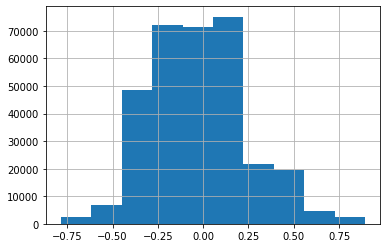

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
    #G.append(0)
  else:
    G.append("male")
    #G.append(1)
dummy['G'] = G

#print(dummy.dtypes)
dummy['ideology'] = dummy['ideology'].astype(float)
dummy = dummy.dropna(subset = ['ideology'])

dummy['ideology'].hist()

In [0]:
q = []
q1,q2,q3 = 0.123,0.25,0.593
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q

In [0]:
dummy['Domain_English'].unique()

Out[30]: array(['Applied Sciences', 'Arts & Humanities',
       'Economic & Social Sciences', 'Health Sciences',
       'Natural Sciences'], dtype=object)

In [0]:
print(merged['media'].nunique())
a = merged.dropna(subset = ['ideology'])
print(a['media'].nunique())


662
547


In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

In [0]:
# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=2)


R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open URL 'https://cran.r-project.org/CRAN_mirrors.csv'); using local file '/usr/lib/R/doc/CRAN_mirrors.csv'

R[write to console]: Error in file(file, "rt") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/local_disk0/.ephemeral_nfs/cluster_libraries/r’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In download.file(url, destfile = f, quiet = TRUE) :
R[write to console]: 
 
R[write to console]:  URL 'https://cran.r-project.org/CRAN_mirrors.csv': Timeout of 60 seconds was reached

R[write to console]: 3: 
R[write to console]: In file(file, "rt") :
R[write to console]: 
 
R[write to console]:  cannot open file '/usr

---------------------------------------------------------------------------
RRuntimeError                             Traceback (most recent call last)
<command-2513506395823> in <cell line: 3>()
      1 # import R's utility package
      2 utils = rpackages.importr('utils')
----> 3 utils.chooseCRANmirror(ind=2)
      4 from rpy2.robjects.conversion import localconverter
      5 base = importr('base')

/local_disk0/.ephemeral_nfs/envs/pythonEnv-819ae590-5edd-4bcd-8a7b-c621f844d8a3/lib/python3.9/site-packages/rpy2/robjects/functions.py in __call__(self, *args, **kwargs)
    201                 v = kwargs.pop(k)
    202                 kwargs[r_k] = v
--> 203         return (super(SignatureTranslatedFunction, self)
    204                 .__call__(*args, **kwargs))
    205 

/local_disk0/.ephemeral_nfs/envs/pythonEnv-819ae590-5edd-4bcd-8a7b-c621f844d8a3/lib/python3.9/site-packages/rpy2/robjects/functions.py in __call__(self, *args, **kwargs)
    124             else:
    125            

In [0]:
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

In [0]:
dummy['Field_English'].unique()

Out[45]: array(['Agriculture, Fisheries & Forestry', 'Built Environment & Design',
       'Enabling & Strategic Technologies', 'Engineering',
       'Information & Communication Technologies',
       'Communication & Textual Studies', 'Historical Studies',
       'Philosophy & Theology', 'Visual & Performing Arts',
       'Economics & Business ', 'Social Sciences', 'Biomedical Research',
       'Clinical Medicine', 'Psychology & Cognitive Sciences',
       'Public Health & Health Services', 'Biology', 'Chemistry',
       'Earth & Environmental Sciences', 'Mathematics & Statistics',
       'Physics & Astronomy'], dtype=object)

In [0]:
tmp = pd.DataFrame()
tmp['ideology'] = dummy['ideology']
tmp['G'] = dummy['G']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']

#tmp = tmp[tmp['Field_English'] == 'Agriculture, Fisheries & Forestry'] #gmale est = -0.013381, p val = 0.0481 *
#tmp = tmp[tmp['Field_English'] == 'Built Environment & Design'] #insig
#tmp = tmp[tmp['Field_English'] == 'Enabling & Strategic Technologies'] #gmale est = -0.013867, p val =  0.01610 * 
#tmp = tmp[tmp['Field_English'] == 'Engineering'] #insig
#tmp = tmp[tmp['Field_English'] == 'Information & Communication Technologies'] #insig
#tmp = tmp[tmp['Field_English'] == 'Historical Studies'] #gmale est = 0.02641 , p val=   0.0364 *  
#tmp = tmp[tmp['Field_English'] == 'Philosophy & Theology'] #insig

#tmp = tmp[tmp['Field_English'] == 'Economics & Business']
#tmp = tmp[tmp['Field_English'] == 'Social Sciences'] #insig
#tmp = tmp[tmp['Field_English'] == 'Biomedical Research']
#tmp = tmp[tmp['Field_English'] == 'Clinical Medicine'] #gmale est = 0.005373, p val 0.000766 ***
#tmp = tmp[tmp['Field_English'] == 'Psychology & Cognitive Sciences'] #insig

#tmp = tmp[tmp['Field_English'] == 'Public Health & Health Services'] #insig
#tmp = tmp[tmp['Field_English'] == 'Biology'] #gmale est = 0.011022, p val= 0.00296 **
#tmp = tmp[tmp['Field_English'] == 'Chemistry'] #gmale est = -0.025871, p val = 0.014056 * 
#tmp = tmp[tmp['Field_English'] == 'Earth & Environmental Sciences'] #insig
#tmp = tmp[tmp['Field_English'] == 'Mathematics & Statistics']
#tmp = tmp[tmp['Field_English'] == 'Physics & Astronomy'] #gmale est = -0.012807, p val=   0.0404 *


with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("ideology ~ G+year",
                  data=tst_df,family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
'''import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')'''

tmp = pd.DataFrame()
tmp['ideology'] = dummy['ideology']
tmp['G'] = dummy['G']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']

tmp = tmp.dropna(subset = ['ideology'])

#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #est Gmale = -0.011384, p val = 0.001634 **
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #est Gmale = 0.009441, p val = 0.00711 **
#tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #insig
#tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #insig


##overall regression, controlling for year, Field_English #gmale est: 0.0020140, pval = 0.03920 *, male gets hitgher value: more positive means more conservative

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2



#print(tst_df)
#pandas2ri.activate()
model = stats.glm("ideology ~ G+year+Field_English+q",
                  data=tst_df,family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
male = merged[merged['G'] == 1]
female = merged[merged['G'] == 0]
male['ideology'] = male['ideology'].astype(float)
print(male['ideology'].mean())
male['ideology'].hist()

In [0]:
female['ideology'] = female['ideology'].astype(float)
print(female['ideology'].mean())

female['ideology'].hist()

## multinomial logit regression analysis for each Field

In [0]:
merged['Field_English'].unique()

Out[41]: array(['Agriculture, Fisheries & Forestry', 'Built Environment & Design',
       'Enabling & Strategic Technologies', 'Engineering',
       'Information & Communication Technologies',
       'Communication & Textual Studies', 'Historical Studies',
       'Philosophy & Theology', 'Visual & Performing Arts',
       'Economics & Business ', 'Social Sciences', 'Biomedical Research',
       'Clinical Medicine', 'Psychology & Cognitive Sciences',
       'Public Health & Health Services', 'Biology', 'Chemistry',
       'Earth & Environmental Sciences', 'Mathematics & Statistics',
       'Physics & Astronomy'], dtype=object)

In [0]:
a = merged[merged['type'] == 'local']
a = a['doi'].unique()
print(len(a))

b = merged[merged['type'] == 'national']
b = b['doi'].unique()
print(len(b))

c = merged[merged['type'] == 'international']
c = c['doi'].unique()
print(len(c))

m1 = set(a).intersection(set(b))
print(len(m1))

m2 = set(m1).intersection(set(c))
print(len(m2))


15999
56348
12057
13886
5973


In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
'''utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)'''
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
nnet = importr('nnet')


In [0]:

def reg(dom,merged):
  dummy = merged.copy()
  dummy = dummy[dummy['Field_English'] == dom]
  print("no of subfield ",dummy['SubField_English'].nunique())
  G = []
  for ind in dummy.index:
    if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
      G.append("female")
    else:
      G.append("male")
  dummy['G'] = G

  tmp = pd.DataFrame()

  tmp['type'] = dummy['type']
  tmp['year'] = dummy['year']
  tmp['Domain_English'] = dummy['Domain_English']
  tmp['Field_English'] = dummy['Field_English']
  tmp['Subfield_English'] = dummy['SubField_English']
  tmp['G'] = dummy['G']
  tmp['SJR'] = dummy['SJR']
  tmp['openaccess_status'] = dummy['openaccess_status']

  #tmp['srcid'] = dummy['srcid']
  #tmp['srcid'] = tmp['srcid'].astype(str)

  tmp = tmp.dropna(subset = ['type'])

  q1 = t['SJR'].quantile(0.25)
  q2 = t['SJR'].quantile(0.50)
  q3 = t['SJR'].quantile(0.75)

  q = []
  for ind in tmp.index:
    if tmp['SJR'][ind] <= q1:
      q.append(0)
    elif tmp['SJR'][ind] > q1 and tmp['SJR'][ind] <= q2:
      q.append(1)
    elif tmp['SJR'][ind] > q2 and tmp['SJR'][ind] <= q3:
      q.append(2)
    else:
      q.append(3)
  tmp['q'] = q

  return tmp



'''category = []
for ind in merged.index:
  if merged['type'][ind] == 'local':
    category.append(0)

  elif merged['type'][ind] == 'national':
    category.append(1)
  elif merged['type'][ind] == 'international':
    category.append(2)
tmp['category'] = category'''


#tmp['srcid'] = tmp['srcid'].astype(str)


##https://stats.oarc.ucla.edu/r/dae/multinomial-logistic-regression/ - for interpretation

#tmp = reg('Agriculture, Fisheries & Forestry',merged) #insig
#tmp = reg('Built Environment & Design',merged) #insig
#tmp = reg('Enabling & Strategic Technologies',merged) #local coefficient = -0.3468981, p val = 8.69660209e-04 (hold for t)
#tmp = reg('Engineering',merged) #insig
#tmp = reg('Information & Communication Technologies',merged) #local coefficient = -0.38352510, pval = 1.75216980e-02 (hold for t)
#tmp = reg('Communication & Textual Studies',merged) #insig
#tmp = reg('Historical Studies',merged) #national coefficient = -0.3030882, p val = 4.20442395e-02 (hold for t)
#tmp = reg('Philosophy & Theology',merged) #insig
#tmp = reg('Visual & Performing Arts',merged) #error
#tmp = reg('Economics & Business ',merged) #insig
#tmp = reg('Social Sciences',merged) #insig
#tmp = reg('Biomedical Research',merged) # local coefficient = -0.19560364, p val = 2.81382585e-06 (hold for t)
#tmp = reg('Clinical Medicine',merged) #local coefficient = -0.07519664, p val = 5.04075784e-003 (hold for t)
#tmp = reg('Psychology & Cognitive Sciences',merged) #local coefficient = -0.11822272, p val = 3.52041006e-02 (hold for t)
#tmp = reg('Public Health & Health Services',merged) #insig
#tmp = reg('Biology',merged) #insig
#tmp = reg('Chemistry',merged) #insig
#tmp = reg('Earth & Environmental Sciences',merged) #loical coefficient = 0.1810558097, p val =6.01319648e-004 (hold for t)
tmp = reg('Mathematics & Statistics',merged) #local coeff = -15.18566, p val = 8.15632124e-045//national coeff = -15.57549, p val = 2.31334740e-090 (does not hold for t, local coeff = -ve, p val = 0.0575, national coeff = +ve)
#tmp = reg('Physics & Astronomy',merged) # national coeff = -0.2437654, p val = 4.56961170e-03 (hold for t)

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2'''

'''col_2_index = list(tst_df.colnames).index('srcid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('srcid'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('Subfield_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Subfield_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

model = nnet.multinom("type ~ G+year+Subfield_English+q+openaccess_status",
                  data=tst_df) 


print(base.summary(model))
#print(base.summary(model).rx2("coefficients")) #run this for r output


#coeffs = base.summary(model).rx2('coefficients')
#std = base.summary(model).rx2('standard.errors')

no of subfield  4
# weights:  42 (26 variable)
initial  value 213.130784 
iter  10 value 111.738760
iter  20 value 107.650631
iter  30 value 107.613295
final  value 107.612770 
converged
Call:
(function (formula, data, weights, subset, na.action, contrasts = NULL, 
    Hess = FALSE, summ = 0, censored = FALSE, model = FALSE, 
    ...) 
{
    class.ind <- function(cl) {
        n <- length(cl)
        x <- matrix(0, n, length(levels(cl)))
        x[(1:n) + n * (as.integer(cl) - 1)] <- 1
        dimnames(x) <- list(names(cl), levels(cl))
        x
    }
    summ2 <- function(X, Y) {
        X <- as.matrix(X)
        Y <- as.matrix(Y)
        n <- nrow(X)
        p <- ncol(X)
        q <- ncol(Y)
        Z <- t(cbind(X, Y))
        storage.mode(Z) <- "double"
        z <- .C(VR_summ2, as.integer(n), as.integer(p), as.integer(q), 
            Z = Z, na = integer(1))
        Za <- t(z$Z[, 1:z$na, drop = FALSE])
        list(X = Za[, 1:p, drop = FALSE], Y = Za[, p + 1:q])
    }
    call <- m

In [0]:
coeffs = base.summary(model).rx2('coefficients')
std = base.summary(model).rx2('standard.errors')
import scipy.stats 

z = np.array(coeffs) / np.array(std)
#print(z)

def my_vectorized_func(m):
    return scipy.stats.norm.sf(abs(m))*2

val = my_vectorized_func(z)
print("printing p value")
print(val)

  
#p_values = (1 - pnorm(abss(z)))*2

# convert to p-values
#p_values <- (1 - pnorm(abs(z_stats)))*2

printing p value
[[5.74850094e-02 5.75329248e-02 4.09970232e-02 0.00000000e+00
  2.90214236e-01 7.39660820e-01 0.00000000e+00 9.96556325e-01
  2.11201598e-01 0.00000000e+00 9.06360162e-01 2.45793277e-40
  2.46811845e-01]
 [6.72773676e-01 1.05138278e-01 3.17211156e-24 0.00000000e+00
  6.44420918e-01 1.73315243e-01 1.83920559e-24 6.00610386e-01
  1.79754441e-02 1.50123414e-54 6.33066686e-01 2.46435969e-54
  9.86622786e-01]]


In [0]:
scipy.stats.norm.sf(abs(-57.26782/30.15302))*2
#(-3.406671e-05)/0.1185584

Out[40]: 0.057532935135273286

## multinomial logit regression for each domain

In [0]:
merged['Domain_English'].unique()

Out[68]: array(['Applied Sciences', 'Arts & Humanities',
       'Economic & Social Sciences', 'Health Sciences',
       'Natural Sciences'], dtype=object)

In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
nnet = importr('nnet')

def reg2(dom,merged):
  dummy = merged.copy()
  dummy = dummy[dummy['Domain_English'] == dom]
  #print("no of subfield ",dummy['SubField_English'].nunique())
  G = []
  for ind in dummy.index:
    if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
      G.append("female")
    else:
      G.append("male")
  dummy['G'] = G

  tmp = pd.DataFrame()

  tmp['type'] = dummy['type']
  tmp['year'] = dummy['year']
  tmp['Domain_English'] = dummy['Domain_English']
  tmp['Field_English'] = dummy['Field_English']
  tmp['Subfield_English'] = dummy['SubField_English']
  tmp['G'] = dummy['G']
  tmp['SJR'] = dummy['SJR']

  #tmp['srcid'] = dummy['srcid']
  #tmp['srcid'] = tmp['srcid'].astype(str)

  tmp = tmp.dropna(subset = ['type'])

  q1 = tmp['SJR'].quantile(0.25)
  q2 = tmp['SJR'].quantile(0.50)
  q3 = tmp['SJR'].quantile(0.75)

  q = []
  for ind in tmp.index:
    if tmp['SJR'][ind] <= q1:
      q.append(0)
    elif tmp['SJR'][ind] > q1 and tmp['SJR'][ind] <= q2:
      q.append(1)
    elif tmp['SJR'][ind] > q2 and tmp['SJR'][ind] <= q3:
      q.append(2)
    else:
      q.append(3)
  tmp['q'] = q

  print("total subfield ", tmp['Subfield_English'].nunique())
  return tmp


#tmp = reg2("Applied Sciences", merged) #local coeff = -0.18166607, p val = 2.89708546e-03
#tmp = reg2("Arts & Humanities", merged) #insig
#tmp = reg2("Economic & Social Sciences", merged) #insig
#tmp = reg2("Health Sciences", merged) #local coeff = -0.077407218, p val = 8.06443180e-005
tmp = reg2("Natural Sciences", merged) #local coeff = 0.07797866, p val = 2.49311072e-02

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('Subfield_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Subfield_English'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

model = nnet.multinom("type ~ G+year+Subfield_English+q",
                  data=tst_df) 


print(base.summary(model))

total subfield  33
# weights:  126 (82 variable)
initial  value 60812.584627 
iter  10 value 49916.085792
iter  20 value 49720.580799
iter  30 value 48998.219351
iter  40 value 48703.151912
iter  50 value 48498.333868
iter  60 value 48432.894978
iter  70 value 48422.172967
iter  80 value 48421.611646
iter  90 value 48421.508552
iter  90 value 48421.508183
iter  90 value 48421.508182
final  value 48421.508182 
converged
Call:
(function (formula, data, weights, subset, na.action, contrasts = NULL, 
    Hess = FALSE, summ = 0, censored = FALSE, model = FALSE, 
    ...) 
{
    class.ind <- function(cl) {
        n <- length(cl)
        x <- matrix(0, n, length(levels(cl)))
        x[(1:n) + n * (as.integer(cl) - 1)] <- 1
        dimnames(x) <- list(names(cl), levels(cl))
        x
    }
    summ2 <- function(X, Y) {
        X <- as.matrix(X)
        Y <- as.matrix(Y)
        n <- nrow(X)
        p <- ncol(X)
        q <- ncol(Y)
        Z <- t(cbind(X, Y))
        storage.mode(Z) <- "doubl

In [0]:
coeffs = base.summary(model).rx2('coefficients')
std = base.summary(model).rx2('standard.errors')
import scipy.stats 

z = np.array(coeffs) / np.array(std)
#print(z)

def my_vectorized_func(m):
    return scipy.stats.norm.sf(abs(m))*2

val = my_vectorized_func(z)
print("printing p value")
print(val)

printing p value
[[4.10339933e-05 2.49311072e-02 3.77787786e-03 1.69647683e-08
  3.89579855e-25 5.53319702e-41 2.35707900e-01 0.00000000e+00
  8.74190610e-05 7.70850713e-04 2.90900578e-04 3.94054361e-01
  9.88605763e-01 2.53118639e-01 7.83747721e-02 7.68308419e-02
  3.67394685e-01 0.00000000e+00 4.00974878e-08 1.16402864e-02
  7.54027454e-02 6.36325074e-02 9.55170237e-01 0.00000000e+00
  9.92121361e-01 9.84210190e-01 4.47600696e-01 0.00000000e+00
  6.00906635e-01 1.08769404e-02 5.22985783e-06 1.72483047e-01
  1.62564392e-01 1.52121383e-03 9.99644853e-01 1.65080106e-04
  3.33633793e-03 1.05943358e-04 1.98975552e-14 1.56763613e-15
  2.72976794e-22]
 [1.25739627e-09 1.62838133e-01 1.54526989e-01 1.85501043e-01
  2.20943517e-02 1.07700314e-01 4.16143282e-01 3.02131509e-01
  5.37915813e-05 2.23436238e-01 4.60596115e-04 8.04755895e-01
  8.79948385e-01 9.02650639e-01 7.14711317e-01 3.35760803e-01
  7.95201779e-02 8.21392331e-01 6.94347965e-03 6.63067649e-01
  5.91252007e-01 1.26577729e-03 8.2

In [0]:
print(scipy.stats.norm.sf(abs(-0.08279810/0.01533569))*2)

6.699609251446652e-08


In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
nnet = importr('nnet')

def reg3(merged):
  dummy = merged.copy()

  #print("no of subfield ",dummy['SubField_English'].nunique())
  G = []
  for ind in dummy.index:
    if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
      G.append("female")
    else:
      G.append("male")
  dummy['G'] = G

  tmp = pd.DataFrame()

  tmp['type'] = dummy['type']
  tmp['year'] = dummy['year']
  tmp['Domain_English'] = dummy['Domain_English']
  tmp['Field_English'] = dummy['Field_English']
  tmp['Subfield_English'] = dummy['SubField_English']
  tmp['G'] = dummy['G']
  tmp['SJR'] = dummy['SJR']

  #tmp['srcid'] = dummy['srcid']
  #tmp['srcid'] = tmp['srcid'].astype(str)

  tmp = tmp.dropna(subset = ['type'])
  print("len of temp ", len(tmp))

  q1 = tmp['SJR'].quantile(0.25)
  q2 = tmp['SJR'].quantile(0.50)
  q3 = tmp['SJR'].quantile(0.75)

  q = []
  for ind in tmp.index:
    if tmp['SJR'][ind] <= q1:
      q.append(0)
    elif tmp['SJR'][ind] > q1 and tmp['SJR'][ind] <= q2:
      q.append(1)
    elif tmp['SJR'][ind] > q2 and tmp['SJR'][ind] <= q3:
      q.append(2)
    else:
      q.append(3)
  tmp['q'] = q

  #print("total subfield ", tmp['Subfield_English'].nunique())
  return tmp



tmp = reg3(merged) #local coeff = -0.08279810, p val = 6.69955729e-008

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

model = nnet.multinom("type ~ G+year+Field_English+q",
                  data=tst_df) 


print(base.summary(model))

len of temp  286071
# weights:  87 (56 variable)
initial  value 314281.116033 
iter  10 value 299680.628902
iter  20 value 294799.354196
iter  30 value 292731.741028
iter  40 value 276900.096394
iter  50 value 267125.870506
iter  60 value 254701.860418
iter  70 value 254243.931000
final  value 254243.697679 
converged
Call:
(function (formula, data, weights, subset, na.action, contrasts = NULL, 
    Hess = FALSE, summ = 0, censored = FALSE, model = FALSE, 
    ...) 
{
    class.ind <- function(cl) {
        n <- length(cl)
        x <- matrix(0, n, length(levels(cl)))
        x[(1:n) + n * (as.integer(cl) - 1)] <- 1
        dimnames(x) <- list(names(cl), levels(cl))
        x
    }
    summ2 <- function(X, Y) {
        X <- as.matrix(X)
        Y <- as.matrix(Y)
        n <- nrow(X)
        p <- ncol(X)
        q <- ncol(Y)
        Z <- t(cbind(X, Y))
        storage.mode(Z) <- "double"
        z <- .C(VR_summ2, as.integer(n), as.integer(p), as.integer(q), 
            Z = Z, na = inte

In [0]:
coeffs = base.summary(model).rx2('coefficients')
std = base.summary(model).rx2('standard.errors')
import scipy.stats 

z = np.array(coeffs) / np.array(std)
#print(z)

def my_vectorized_func(m):
    return scipy.stats.norm.sf(abs(m))*2

val = my_vectorized_func(z)
print("printing p value")
print(val)

printing p value
[[9.66328066e-186 6.69955729e-008 1.02345993e-002 1.55949035e-053
  6.03868779e-048 0.00000000e+000 2.62232045e-008 7.84341322e-015
  4.33180887e-001 3.96668141e-030 6.68184492e-001 4.96358158e-001
  2.82479237e-014 4.40938302e-004 2.33713476e-011 1.28357878e-008
  1.06269033e-031 9.33075050e-011 4.53088275e-002 5.83019377e-002
  2.00340016e-108 7.03110936e-016 2.48739860e-016 1.00785408e-012
  1.84137589e-007 1.96983624e-003 3.24715591e-011 1.12856633e-031]
 [9.93586616e-284 4.59824971e-001 6.54103408e-001 1.04844946e-001
  6.13053888e-004 1.13043999e-005 9.16842739e-004 5.43316367e-010
  8.86416053e-001 2.25160305e-002 2.56028416e-004 7.35326581e-001
  1.54495894e-011 1.25466517e-002 2.43197872e-002 8.00240533e-003
  6.53407461e-014 1.53237733e-008 1.48485338e-001 9.31599996e-001
  3.32370059e-003 3.26884790e-016 1.44635047e-001 1.17366376e-002
  3.77145657e-007 5.91484821e-002 3.13973865e-009 2.25190774e-038]]


## top 5% local

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
    #G.append(0)
  else:
    G.append("male")
    #G.append(1)
dummy['G'] = G


local = dummy[dummy['type'] == 'local']
#print(local.head(5))

top10 = local['doi'].value_counts().reset_index()

top10.columns = ['doi','counts']

#print(top10.tail(10))
#print(len(top10))

# Calculate the threshold for the top 5%
threshold = top10['counts'].quantile(0.95)

# Select rows with 'money' values in the top 5%
top10 = top10[top10['counts'] >= threshold]

print(len(top10),"\n")
print("threshold ",threshold,"\n")
print(top10.tail(5))

859 

threshold  27.0 

                                 doi  counts
854  10.1001/jamainternmed.2021.5022      27
855            10.1093/alcalc/agy061      27
856    10.1080/19496591.2018.1474752      27
857        10.1148/radiol.2020191413      27
858       10.1016/j.stem.2020.11.010      27


In [0]:
a = pd.DataFrame()
a['doi'] = dummy['doi']
a['G'] = dummy['G']
a = a.drop_duplicates()

top10_merged = a.merge(top10, on = ['doi'], how = 'inner')
local_top = top10_merged['doi'].unique()
print(len(top10_merged),"\n")

print("percent of female in top 10% highly cited doi by local newspaper ",len(top10_merged[top10_merged['G'] == "female"])/len(top10_merged))

859 

percent of female in top 10% highly cited doi by local newspaper  0.3608847497089639


## top 5% national

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
    #G.append(0)
  else:
    G.append("male")
    #G.append(1)
dummy['G'] = G

national = dummy[dummy['type'] == 'national']


top10 = national['doi'].value_counts().reset_index()

top10.columns = ['doi','counts']

#print(top10.tail(10))
#print(len(top10))

# Calculate the threshold for the top 5%
threshold = top10['counts'].quantile(0.95)

# Select rows with 'money' values in the top 5%
top10 = top10[top10['counts'] >= threshold]

print(len(top10),"\n")
print("threshold ",threshold,"\n")
print(top10.tail(5))

a = pd.DataFrame()
a['doi'] = dummy['doi']
a['G'] = dummy['G']
a = a.drop_duplicates()

top10_merged = a.merge(top10, on = ['doi'], how = 'inner')
print(len(top10_merged),"\n")

national_top = top10_merged['doi'].unique()

print("percent of female in top 10% highly cited doi by national newspaper ",len(top10_merged[top10_merged['G'] == "female"])/len(top10_merged))

3143 

threshold  7.0 

                                doi  counts
3138      10.1038/s41370-018-0064-7       7
3139  10.1080/02791072.2020.1836435       7
3140     10.1007/s10902-020-00236-6       7
3141  10.1016/j.jpubeco.2017.09.008       7
3142      10.1007/s11606-018-4703-4       7
3143 

percent of female in top 10% highly cited doi by national newspaper  0.3534839325485205


## top 5% International

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
    #G.append(0)
  else:
    G.append("male")
    #G.append(1)
dummy['G'] = G

international = dummy[dummy['type'] == 'international']


top10 = international['doi'].value_counts().reset_index()

top10.columns = ['doi','counts']

#print(top10.tail(10))
#print(len(top10))

# Calculate the threshold for the top 5%
threshold = top10['counts'].quantile(0.95)

# Select rows with 'money' values in the top 5%
top10 = top10[top10['counts'] >= threshold]

print(len(top10),"\n")
print("threshold ",threshold,"\n")
print(top10.tail(5))

a = pd.DataFrame()
a['doi'] = dummy['doi']
a['G'] = dummy['G']
a = a.drop_duplicates()

top10_merged = a.merge(top10, on = ['doi'], how = 'inner')
print(len(top10_merged),"\n")

international_top = top10_merged['doi'].unique()

print("percent of female in top 10% highly cited doi by international newspaper ",len(top10_merged[top10_merged['G'] == "female"])/len(top10_merged))

829 

threshold  5.0 

                            doi  counts
824     10.1126/science.aao6379       5
825      10.1126/sciadv.abb9153       5
826   10.1038/s41591-020-1007-0       5
827  10.1038/s41586-021-03594-0       5
828      10.1098/rspb.2021.1997       5
829 

percent of female in top 10% highly cited doi by international newspaper  0.30759951749095293


In [0]:
print(len(local_top))
print(len(national_top))
print(len(international_top))

m1 = set(local_top).intersection(set(national_top))
print(len(m1))

m2 = set(m1).intersection(set(international_top))
print(len(m2))

859
3143
829
585
216


In [0]:
print(216/859)
print(216/3143)
print(216/829)

0.25145518044237486
0.06872414890232262
0.2605548854041013


## testing

In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
nnet = importr('nnet')
mlogit = importr('mlogit')

tmp = merged.dropna(subset = ['type'])
category = []
for ind in merged.index:
  if merged['type'][ind] == 'local':
    category.append(0)

  elif merged['type'][ind] == 'national':
    category.append(1)
  elif merged['type'][ind] == 'international':
    category.append(2)
tmp['category'] = category

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('category')
col_2 = ro.vectors.FactorVector(tst_df.rx2('category'))
tst_df[col_2_index] = col_2

model = mlogit.mlogit(formula = Formula("category ~ G+year"),
                  data=tst_df) 

#model = VGAM.vglm("category ~ G+year",
#                  data=tst_df, family = ro.r('multinomial')) 


print(base.summary(model))

In [0]:
print(base.summary(model).rx2('coefficients'))

In [0]:

import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages("mlogit")
utils.install_packages("VGAM")

VGAM = importr('VGAM')

mlogit = importr('mlogit')